# Assignment 4: Cifar-10 

# A study in Very Deep Convolutional Neural Networks

In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import datetime
import os
from collections import OrderedDict
import time
import tflearn
import tensorflow.contrib.slim as slim
import pickle as pcl

%matplotlib inline
plt.style.use('ggplot')

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)
test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']

valid_inputs = valid_data.inputs
valid_targets = valid_data.to_one_of_k(valid_data.targets)

def weight_variable(shape, i):
    initial = tf.contrib.layers.variance_scaling_initializer()
    return tf.get_variable('W_'+i,shape=shape,initializer=initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def write_to_file(newfile, run_info):
    with open(newfile,'wb') as outfile:
        pcl.dump(run_info,outfile)

def read_from_file(newfile):
    run_info = pcl.load(open(newfile,'r'))
    return run_info

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
def plot_error_and_accuracy(diction, filename):
    fig = plt.figure(figsize=(12, 6))
    fig2 = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax3 = fig2.add_subplot(1,2,1)
    ax4 = fig2.add_subplot(1,2,2)
    x=np.arange(30) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label=str(labels))
        ax2.plot(x, 
                 error_valid_all, label=str(labels))
        ax3.plot(x, 
                 acc_all, label=str(labels))
        ax4.plot(x, 
                 acc_valid_all, label=str(labels))

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    fig.tight_layout() 
    fig.savefig(filename+'_err.png') 
    #ax2.set_yscale('log')
    
    
    ax3.legend(loc=0)
    ax3.set_xlabel('Epoch number')
    ax3.set_ylabel('Training set accuracy')
    ax4.legend(loc=0)
    ax4.set_xlabel('Epoch number')
    ax4.set_ylabel('Validation set accuracy')
    fig2.tight_layout() # This minimises whitespace around the axes.
    fig2.savefig(filename+'_acc.png') # Save figure to current directory in PDF format
    plt.show()

In [3]:
def plot_error_and_accuracy_single(diction, filename):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    x=np.arange(120) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label='Training Set Error')
        ax1.plot(x, 
                 error_valid_all, label='Validation Set Error')
        ax2.plot(x, 
                 acc_all, label='Training Set Accuracy')
        ax2.plot(x, 
                 acc_valid_all, label='Validation Set Accuracy')

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training & Validation set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Training & Validation set Accuracy')
    fig.tight_layout() 
    fig.savefig(filename+'.png') 
    #ax2.set_yscale('log')
    plt.show

### Baseline model

In [15]:
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

run_info = {}
labels = ['1_layer','3_layers','5_layers', '8_layers', '14_layers']
num_layers = [1,3,5,8,14]
hidden_l = [None]*15

for label, num_layer in zip(labels,num_layers):

    tf.reset_default_graph()
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])


    
    
        with tf.name_scope('fc-layer-1'):
            fc_1 = fully_connected_layer(x, train_data.inputs.shape[1], 600, tf.nn.relu)
            batch1 = batch(fc_1,is_training_ph, 'first')
            hidden_l[0] = tf.nn.dropout(batch1, keep_prob) 
        for i in range(1,num_layer):
            with tf.name_scope('fc-layer-' + str(i+1)):
                fc = fully_connected_layer(hidden_l[i-1], 600, 600, tf.nn.relu)
                batch_l = batch(fc,is_training_ph, str(i))
                hidden_l[i] = tf.nn.dropout(batch_l, keep_prob) 
                
        with tf.name_scope('output-layer'):
            y_out = fully_connected_layer(hidden_l[num_layer-1], 600, train_data.num_classes, tf.identity)
        

        with tf.name_scope('error'):
            net_vars   = tf.trainable_variables()  
            lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in net_vars
                       if 'biases' not in v.name ]) 
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + lossL2*0.0001),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=0.01,momentum=0.9).minimize(error)

        init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, keep_prob: 0.8})
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 1_layer
End of epoch 01: err(train)=2.1082 acc(train)=0.3203
                 err(valid)=1.8065 acc(valid)=0.3618
-- 8.141849517822266 secs ---
End of epoch 02: err(train)=1.9440 acc(train)=0.3579
                 err(valid)=1.7902 acc(valid)=0.3730
-- 6.402293920516968 secs ---
End of epoch 03: err(train)=1.8674 acc(train)=0.3808
                 err(valid)=1.7562 acc(valid)=0.3863
-- 6.133975982666016 secs ---
End of epoch 04: err(train)=1.8209 acc(train)=0.3928
                 err(valid)=1.6962 acc(valid)=0.4094
-- 6.402549982070923 secs ---
End of epoch 05: err(train)=1.7832 acc(train)=0.4039
                 err(valid)=1.6607 acc(valid)=0.4268
-- 6.196038007736206 secs ---
End of epoch 06: err(train)=1.7666 acc(train)=0.4112
                 err(valid)=1.6397 acc(valid)=0.4305
-- 6.653486967086792 secs ---
End of epoch 07: err(train)=1.7656 acc(train)=0.4119
                 err(valid)=1.6371 acc(valid)=0.4320
-- 6.3470799922943115 secs ---
End of epoch 08: err(train)=1.76

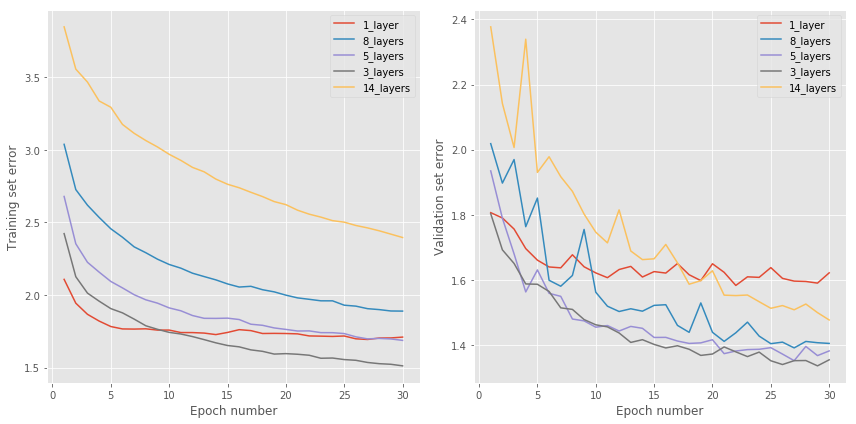

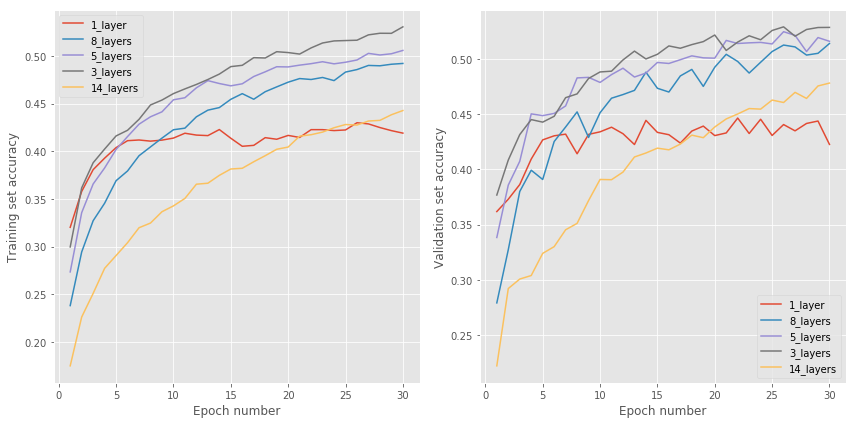

In [16]:
write_to_file('baseline.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_baseline')

## VGG Network

In [11]:
def stackUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("stack_unit"+str(i)):

        part1 = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part2 = batch(part1,is_training_ph, str(i)+"_"+str(1))
        part3 = tf.nn.relu(part2)
        
        part4 = slim.conv2d(part3,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part5 = batch(part4,is_training_ph, str(i)+"_"+str(2))
        output = tf.nn.relu(part5)
        
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1, keep_prob: 0.5})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01, keep_prob:0.5})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001, keep_prob:0.5})
    return batch_error, batch_acc

In [12]:
run_info = {}
labels = ['8_layers','14_layers','20_layers']
num_layers = [1,2,3]

for label, num_layer in zip(labels,num_layers):
    filters = [16,32,64]
    tf.reset_default_graph()
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3
        layer1 = x_image

        for i in range(3):
            print (i)
            for j in range(num_layer):
                print (j)
                layer1 = stackUnit(layer1,j + 3*i, filters[i], j , i, is_training_ph)
            layer1 = max_pool_2x2(layer1)

        res = tf.reshape(layer1,[-1, 4*4*64])

        with tf.name_scope('fully_connected_stack'):
            w_1 = weight_variable([4*4*64, 1024], str(1))
            b1 = bias_variable([1024])
            fc1 = tf.matmul(res, w_1) + b1
            batch1 = batch(fc1,is_training_ph, "fc1")
            nofc1 = tf.nn.relu(batch1)
            drop1 = tf.nn.dropout(nofc1, keep_prob)

            w_2 = weight_variable([4*4*64, 1024], str(2))
            b2 = bias_variable([1024])
            fc2 = tf.matmul(drop1, w_2) + b2
            batch2 = batch(fc2,is_training_ph, "fc2")
            nofc2 = tf.nn.relu(batch2)
            drop2 = tf.nn.dropout(nofc2, keep_prob)

            w_3 = weight_variable([1024, 10], str(3))
            b3 = bias_variable([10])
            y_out = tf.matmul(drop2, w_3) + b3    

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            regularizers = regularizers = tf.reduce_sum(tf.square(w_1)) + tf.reduce_sum(tf.square(w_2)) + tf.reduce_sum(tf.square(w_3))
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.00001*regularizers+tf.reduce_sum(reg_losses))),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            #with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
            train_step =tf.train.MomentumOptimizer(learning_rate=0.1,momentum=0.9).minimize(error)

        init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))



0
0
1
0
2
0
Model: 8_layers
End of epoch 01: err(train)=2.7099 acc(train)=0.2037
                 err(valid)=1.8750 acc(valid)=0.3245
-- 33.34952926635742 secs ---
End of epoch 02: err(train)=1.8932 acc(train)=0.3388
                 err(valid)=1.6831 acc(valid)=0.3854
-- 31.35499119758606 secs ---
End of epoch 03: err(train)=1.7193 acc(train)=0.4043
                 err(valid)=1.6414 acc(valid)=0.4078
-- 31.70628023147583 secs ---
End of epoch 04: err(train)=1.6107 acc(train)=0.4537
                 err(valid)=1.3994 acc(valid)=0.5002
-- 31.451222896575928 secs ---
End of epoch 05: err(train)=1.5788 acc(train)=0.4720
                 err(valid)=1.4255 acc(valid)=0.4885
-- 31.557811737060547 secs ---
End of epoch 06: err(train)=1.4542 acc(train)=0.5151
                 err(valid)=1.6147 acc(valid)=0.4685
-- 31.755163431167603 secs ---
End of epoch 07: err(train)=1.4163 acc(train)=0.5320
                 err(valid)=1.2176 acc(valid)=0.5692
-- 31.41092586517334 secs ---
End of epoch 08: 

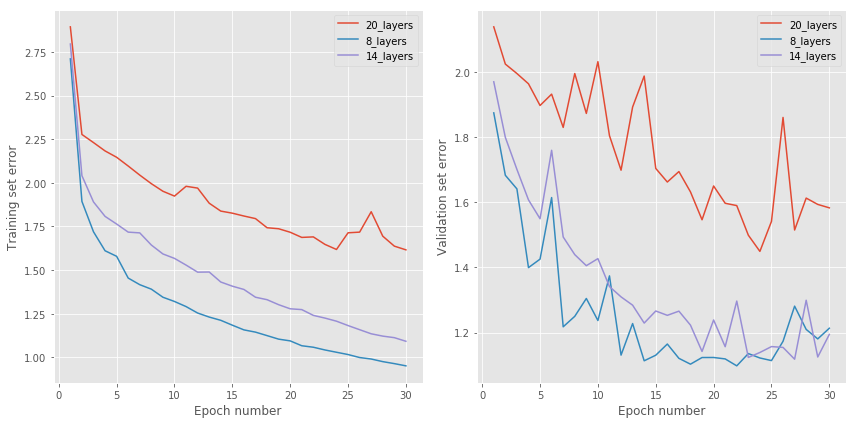

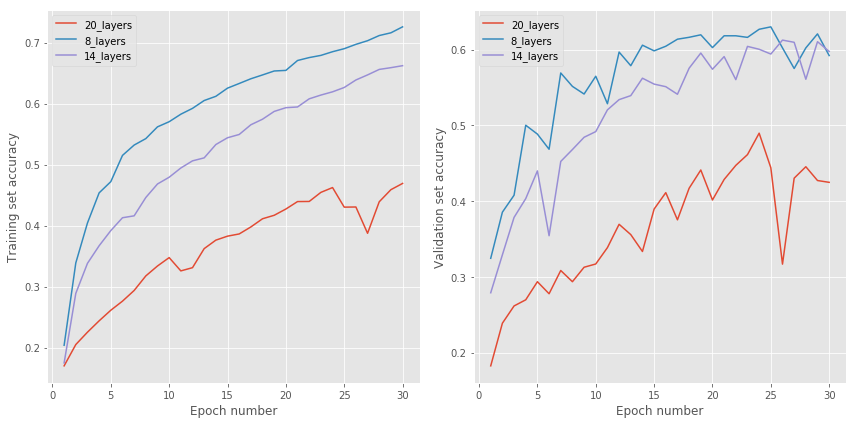

In [13]:
write_to_file('VGG_net.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_VGG')


# Plain Deep Network

In [5]:
def stackUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("stack_unit"+str(i)):

        part1 = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part2 = batch(part1,is_training_ph, str(i)+"_"+str(1))
        part3 = tf.nn.relu(part2)
        
        part4 = slim.conv2d(part3,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part5 = batch(part4,is_training_ph, str(i)+"_"+str(2))
        output = tf.nn.relu(part5)
        
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1, keep_prob: 0.5})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01, keep_prob:0.5})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001, keep_prob:0.5})
    return batch_error, batch_acc

In [6]:
run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        layer1 = batch(layer1,is_training_ph, 'first')
        layer1 = tf.nn.relu(layer1)
        for i in range(3):
            for j in range(num_layer):
                layer1 = stackUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,10,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([10, 10], str(1))
        b_fc2 = bias_variable([10])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))




Model: 24_layers
End of epoch 01: err(train)=1.9564 acc(train)=0.2750
                 err(valid)=1.9921 acc(valid)=0.2652
-- 91.30202889442444 secs ---
End of epoch 02: err(train)=1.7066 acc(train)=0.3753
                 err(valid)=1.6804 acc(valid)=0.3795
-- 87.71829032897949 secs ---
End of epoch 03: err(train)=1.5838 acc(train)=0.4256
                 err(valid)=1.4980 acc(valid)=0.4529
-- 85.37398505210876 secs ---
End of epoch 04: err(train)=1.4936 acc(train)=0.4651
                 err(valid)=1.4211 acc(valid)=0.4868
-- 85.2911388874054 secs ---
End of epoch 05: err(train)=1.4249 acc(train)=0.4927
                 err(valid)=1.6492 acc(valid)=0.3985
-- 85.25311493873596 secs ---
End of epoch 06: err(train)=1.3621 acc(train)=0.5182
                 err(valid)=1.6490 acc(valid)=0.4441
-- 85.33350610733032 secs ---
End of epoch 07: err(train)=1.3132 acc(train)=0.5387
                 err(valid)=1.3099 acc(valid)=0.5281
-- 85.24534964561462 secs ---
End of epoch 08: err(train)=1.27

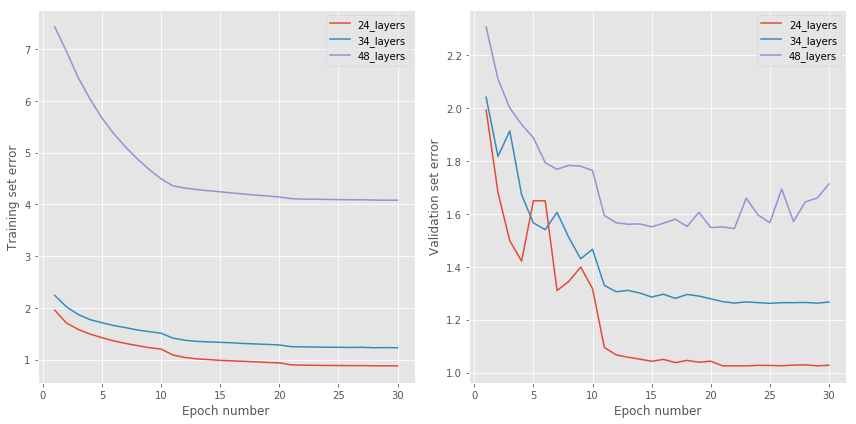

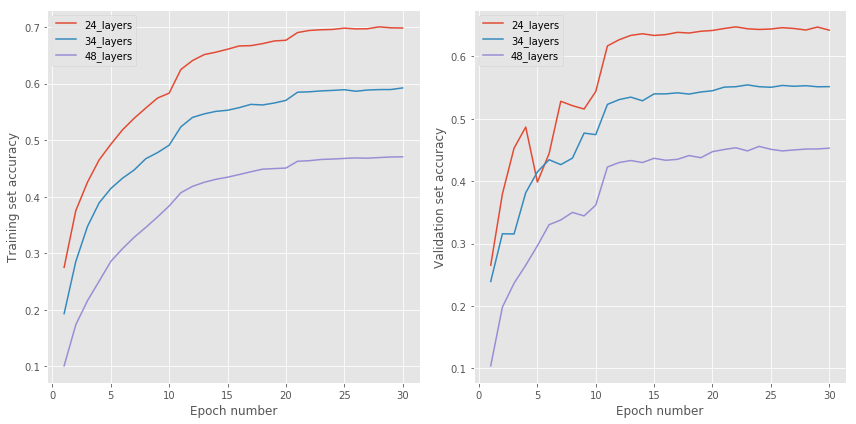

In [7]:
write_to_file('CIFAR10_plainNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_plainNet')

## Residual Network

In [12]:
def resUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = batch(input_layer,is_training_ph, str(i)+"_"+str(1))
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
        #print (part3.shape)
        part4 = batch(part3, is_training_ph, str(i)+"_"+str(2))
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
        #print (part4.shape)
        if j==0 and k!=0:
            input_padded = tf.pad(input_layer, [[0, 0], [0, 0], [0, 0], [filters // 4, filters // 4]])
            #print (input_paded.shape)
            output = input_padded + part6 # change to input padded
        else:
            output = input_layer + part6
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc
        

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        for i in range(3):
            
            for j in range(num_layer):
                layer1 = resUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,10,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([10, 10], str(1))
        b_fc2 = bias_variable([10])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))



Model: 24_layers
End of epoch 01: err(train)=1.5546 acc(train)=0.3216
                 err(valid)=1.4704 acc(valid)=0.4621
-- 76.95307660102844 secs ---
End of epoch 02: err(train)=1.4340 acc(train)=0.5132
                 err(valid)=1.2378 acc(valid)=0.5620
-- 86.83825373649597 secs ---
End of epoch 03: err(train)=1.2629 acc(train)=0.5832
                 err(valid)=1.2150 acc(valid)=0.5779
-- 86.31486201286316 secs ---
End of epoch 04: err(train)=1.1652 acc(train)=0.6229
                 err(valid)=1.0961 acc(valid)=0.6212
-- 86.2494330406189 secs ---
End of epoch 05: err(train)=1.0905 acc(train)=0.6558
                 err(valid)=1.0315 acc(valid)=0.6401
-- 87.9932975769043 secs ---
End of epoch 06: err(train)=1.0390 acc(train)=0.6792
                 err(valid)=1.0644 acc(valid)=0.6244
-- 90.13213467597961 secs ---
End of epoch 07: err(train)=0.9905 acc(train)=0.7017
                 err(valid)=1.0998 acc(valid)=0.6182
-- 88.04609417915344 secs ---
End of epoch 08: err(train)=0.951

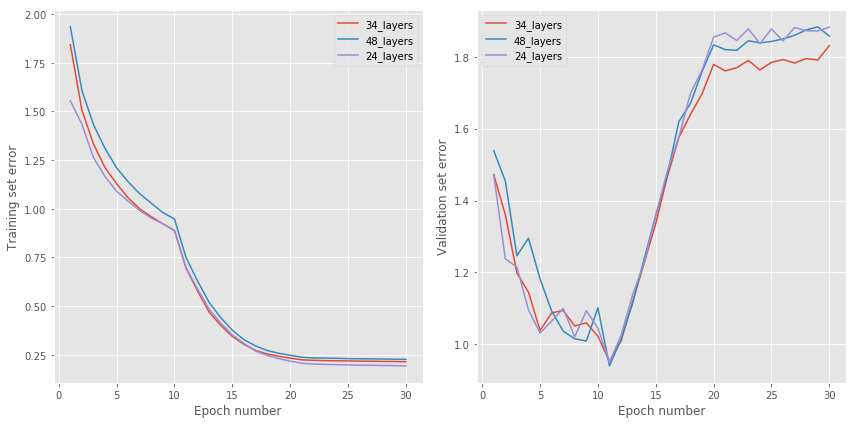

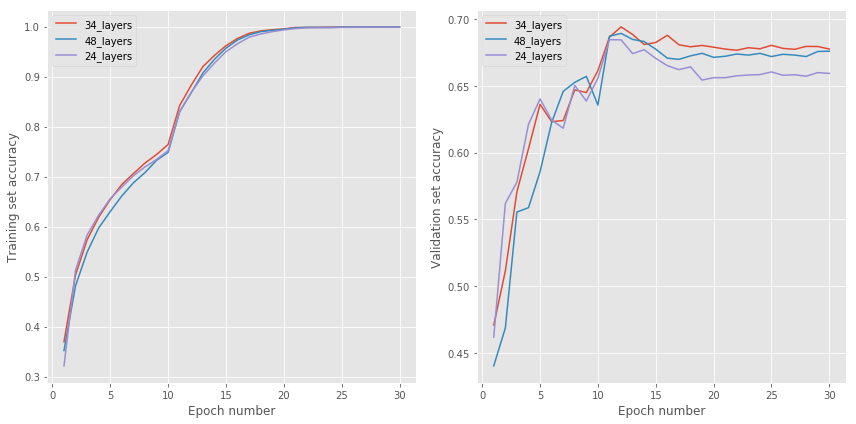

In [13]:
write_to_file('CIFAR10_ResNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_ResNet')

### Option B

In [4]:
def resUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = batch(input_layer,is_training_ph, str(i)+"_"+str(1))
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
        #print (part3.shape)
        part4 = batch(part3, is_training_ph, str(i)+"_"+str(2))
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
        #print (part4.shape)
        if j==0 and k!=0:
            input_padded = slim.conv2d(input_layer,filters,[1,1],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
            #print (input_paded.shape)
            output = input_padded + part6 # change to input padded
        else:
            output = input_layer + part6
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc
        

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        for i in range(3):
            
            for j in range(num_layer):
                layer1 = resUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,10,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([10, 10], str(1))
        b_fc2 = bias_variable([10])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))



Model: 24_layers
End of epoch 01: err(train)=1.6731 acc(train)=0.4219
                 err(valid)=1.4309 acc(valid)=0.4813
-- 90.860675573349 secs ---
End of epoch 02: err(train)=1.3766 acc(train)=0.5384
                 err(valid)=1.2656 acc(valid)=0.5532
-- 87.87011671066284 secs ---
End of epoch 03: err(train)=1.2451 acc(train)=0.5918
                 err(valid)=1.2730 acc(valid)=0.5563
-- 89.86405491828918 secs ---
End of epoch 04: err(train)=1.1545 acc(train)=0.6286
                 err(valid)=1.1159 acc(valid)=0.6048
-- 88.0660331249237 secs ---
End of epoch 05: err(train)=1.0898 acc(train)=0.6578
                 err(valid)=1.3901 acc(valid)=0.5270
-- 88.15598797798157 secs ---
End of epoch 06: err(train)=1.0366 acc(train)=0.6800
                 err(valid)=1.1315 acc(valid)=0.6053
-- 88.37799143791199 secs ---
End of epoch 07: err(train)=0.9964 acc(train)=0.6983
                 err(valid)=1.0304 acc(valid)=0.6446
-- 89.46943044662476 secs ---
End of epoch 08: err(train)=0.9577

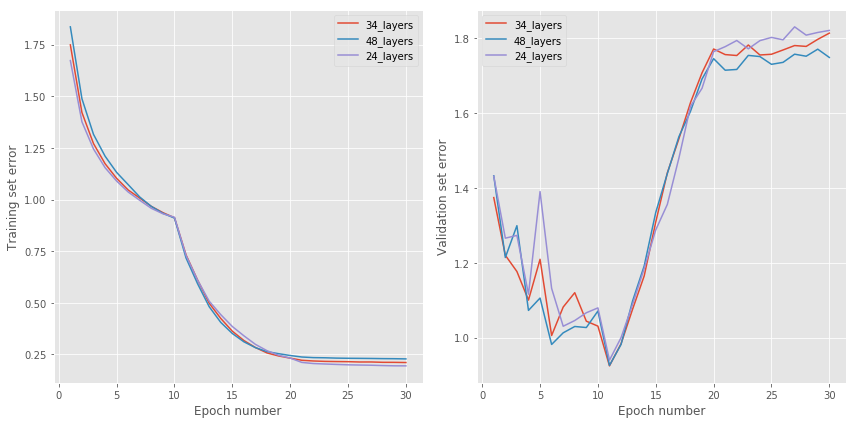

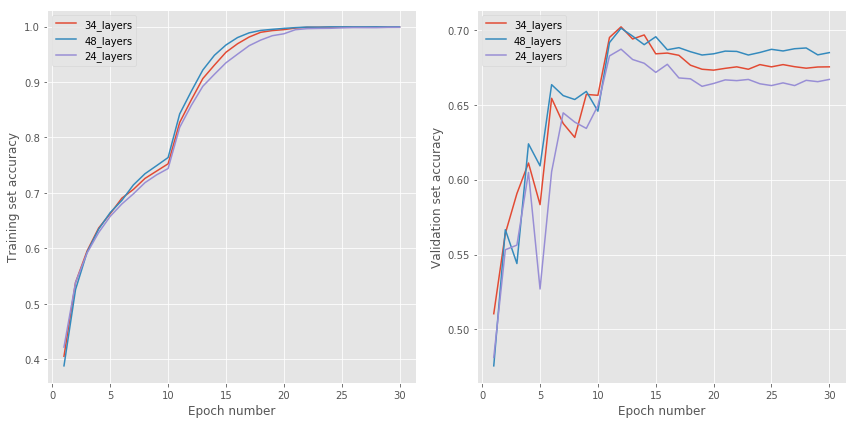

In [5]:
write_to_file('CIFAR10_ResNet_optB.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_ResNet_optB')

# Highway Net

In [17]:
import tensorflow.contrib.slim as slim

def highwayUnit(input_layer,i,filters,j , k):
    with tf.variable_scope("highway_unit"+str(i)):
        H = slim.conv2d(input_layer,filters,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001))
        T = slim.conv2d(input_layer,filters,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.0001),\
                            biases_initializer=tf.constant_initializer(-1.0),activation_fn=tf.nn.sigmoid)
        
        if j==0 and k!=0:
            input_padded = tf.pad(input_layer, [[0, 0], [0, 0], [0, 0], [filters // 4, filters // 4]])
            output = H*T + input_padded*(1.0-T) # change to input padded
        else:
            output = H*T + input_layer*(1.0-T)
        return output

        
run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)
        
        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3
        layer1 = slim.conv2d(x_image,16,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                weights_regularizer=slim.l2_regularizer(0.0001),normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
        for i in range(3):
            for j in range(num_layer):
                layer1 = highwayUnit(layer1,j + (i*num_layer), filters[i], j , i)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                weights_regularizer=slim.l2_regularizer(0.0001),stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))

        top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')


        top_c = tflearn.global_avg_pool(top)

        W_fc2 = weight_variable([10, 10], str(1))
        b_fc2 = bias_variable([10])
        y_out = tf.matmul(top_c, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
                #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
        
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 24_layers
End of epoch 01: err(train)=1.6415 acc(train)=0.4352
                 err(valid)=1.3610 acc(valid)=0.5162
-- 61.59592127799988 secs ---
End of epoch 02: err(train)=1.3633 acc(train)=0.5499
                 err(valid)=1.2105 acc(valid)=0.5766
-- 60.30101275444031 secs ---
End of epoch 03: err(train)=1.2373 acc(train)=0.6022
                 err(valid)=1.1751 acc(valid)=0.5837
-- 60.033655643463135 secs ---
End of epoch 04: err(train)=1.1564 acc(train)=0.6381
                 err(valid)=1.0793 acc(valid)=0.6250
-- 60.09977674484253 secs ---
End of epoch 05: err(train)=1.1050 acc(train)=0.6625
                 err(valid)=1.0766 acc(valid)=0.6250
-- 60.25573396682739 secs ---
End of epoch 06: err(train)=1.0654 acc(train)=0.6823
                 err(valid)=1.0456 acc(valid)=0.6381
-- 59.97648906707764 secs ---
End of epoch 07: err(train)=1.0313 acc(train)=0.6990
                 err(valid)=1.0589 acc(valid)=0.6371
-- 59.97555351257324 secs ---
End of epoch 08: err(train)=1.

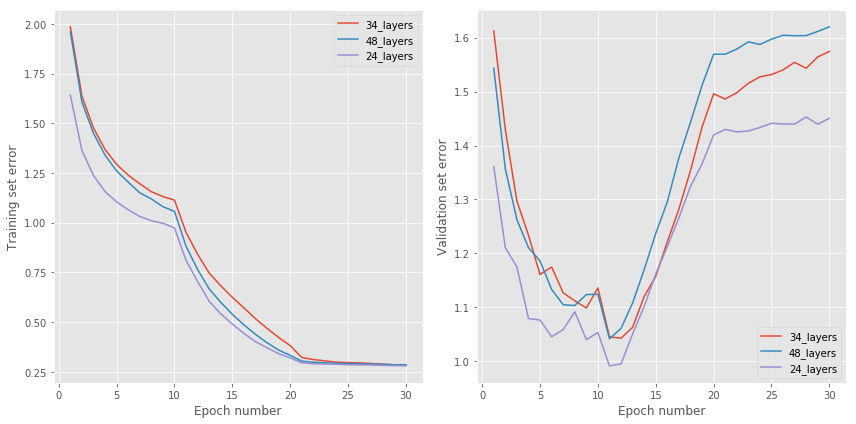

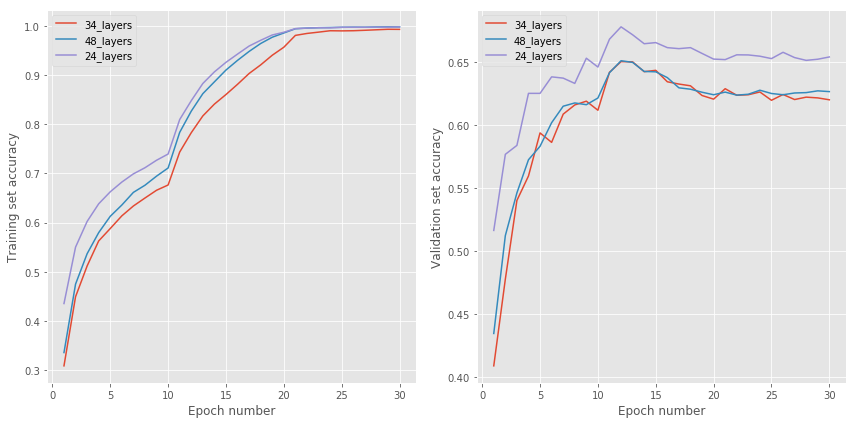

In [18]:
write_to_file('CIFAR10_HighwayNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_HighwayNet')

# Dense Network

In [18]:
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output


def denseUnit(input_layer,i,j,is_training_ph, keep_prob,filters):
    with tf.variable_scope("dense_unit"+str(i)):
        nodes = []
        a = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0+j*i))
        a = batch(a,is_training_ph, str(0 + j*i))
        a = tf.nn.relu(a)
        a = tf.nn.dropout(a, keep_prob)
        nodes.append(a)
        for z in range(j):
            b = slim.conv2d(tf.concat(nodes,3),filters,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(z+1+j*i))
            b = batch(b,is_training_ph, str(z+1 + j*i))
            b = tf.nn.relu(b)
            b = tf.nn.dropout(b, keep_prob)
            nodes.append(b)
        return b
    
def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1,keep_prob:0.8})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01,keep_prob:0.8})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001,keep_prob:0.8})
    return batch_error, batch_acc

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph    
    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        layer1 = batch(layer1,is_training_ph, "first")
        layer1 = tf.nn.relu(layer1)
        
        for i in range(3):
            layer1 = denseUnit(layer1,i,num_layer,is_training_ph, keep_prob, filters[i])
            layer1 = slim.conv2d(layer1,filters[i],[1,1],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))
            layer1 = batch(layer1,is_training_ph, "transit"+str(i))
            layer1 = tf.nn.relu(layer1)
            layer1 = tf.nn.dropout(layer1, keep_prob)
            layer1 = tf.nn.avg_pool(layer1,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        output_layer = slim.conv2d(layer1,10,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')
        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top_c = tf.nn.dropout(top_c, keep_prob)
        
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([10, 10], str(1))
        b_fc2 = bias_variable([10])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)
        init = tf.global_variables_initializer()
        
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 24_layers
End of epoch 01: err(train)=1.8135 acc(train)=0.3519
                 err(valid)=1.7664 acc(valid)=0.3561
-- 96.53863406181335 secs ---
End of epoch 02: err(train)=1.5766 acc(train)=0.4531
                 err(valid)=1.7559 acc(valid)=0.4492
-- 92.18742036819458 secs ---
End of epoch 03: err(train)=1.4633 acc(train)=0.5011
                 err(valid)=1.2885 acc(valid)=0.5400
-- 92.13947629928589 secs ---
End of epoch 04: err(train)=1.4029 acc(train)=0.5299
                 err(valid)=1.4400 acc(valid)=0.5135
-- 92.17240881919861 secs ---
End of epoch 05: err(train)=1.3597 acc(train)=0.5509
                 err(valid)=1.6251 acc(valid)=0.4783
-- 92.2126944065094 secs ---
End of epoch 06: err(train)=1.3311 acc(train)=0.5639
                 err(valid)=1.2527 acc(valid)=0.5774
-- 92.20823359489441 secs ---
End of epoch 07: err(train)=1.2947 acc(train)=0.5782
                 err(valid)=1.1478 acc(valid)=0.5973
-- 92.29860258102417 secs ---
End of epoch 08: err(train)=1.27

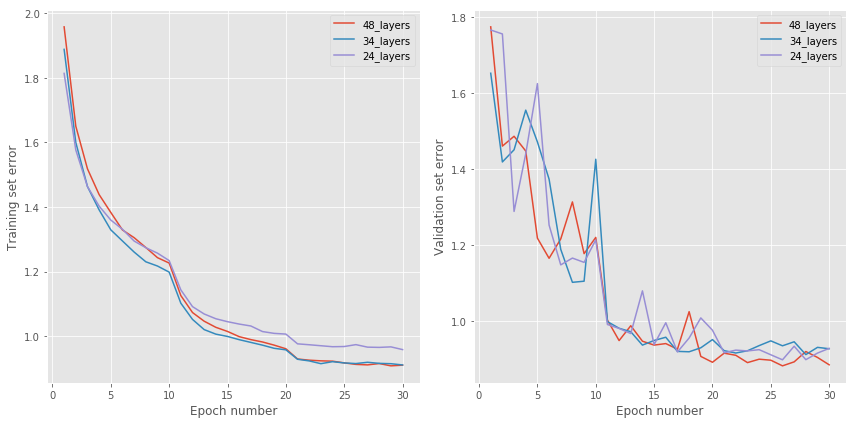

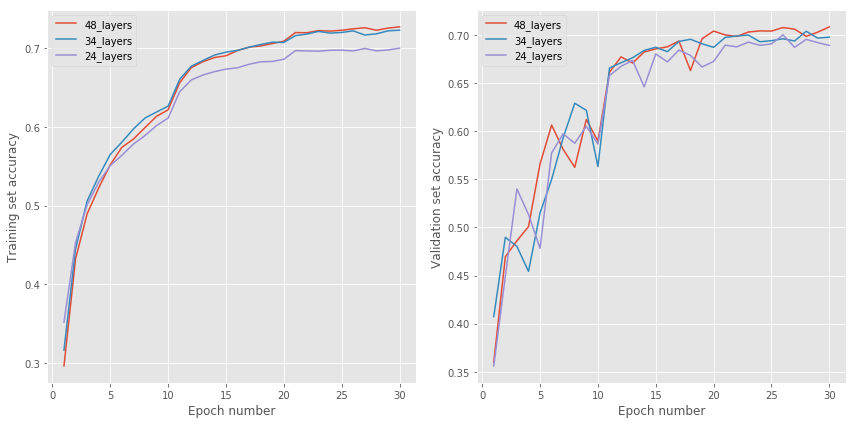

In [19]:
write_to_file('CIFAR10_DenseNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR10_DenseNet')